In [13]:
import glob
import pandas as pd
import re
import spacy
import gensim
import seaborn as sns
from scipy import spatial


from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer


kTOKENIZER = TreebankWordTokenizer()
nlp = spacy.load('en')

In [32]:
import multiprocessing
multiprocessing.cpu_count()

12

In [14]:
def cosine_similarity(a,b):
    result = 1 - spatial.distance.cosine(a, b)
    return result

In [15]:
data = pd.read_csv('./data/ROCStories__spring2016 - ROCStories_spring2016.csv')

In [16]:
data.head(5)

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,9a51198e-96f1-42c3-b09d-a3e1e067d803,Overweight Kid,Dan's parents were overweight.,Dan was overweight as well.,The doctors told his parents it was unhealthy.,His parents understood and decided to make a c...,They got themselves and Dan on a diet.
1,617e7ada-3878-488d-bd56-40695b91f053,The Bike Accident,Carrie had just learned how to ride a bike.,She didn't have a bike of her own.,Carrie would sneak rides on her sister's bike.,She got nervous on a hill and crashed into a w...,The bike frame bent and Carrie got a deep gash...
2,79b0da1f-e460-4173-ba58-8c9e2553c53a,Beach,Morgan enjoyed long walks on the beach.,She and her boyfriend decided to go for a long...,"After walking for over a mile, something happe...",Morgan decided to propose to her boyfriend.,Her boyfriend was upset he didn't propose to h...
3,d173b7de-4611-4cdf-934c-912834755e41,The bad customer.,Jane was working at a diner.,"Suddenly, a customer barged up to the counter.",He began yelling about how long his food was t...,Jane didn't know how to react.,"Luckily, her coworker intervened and calmed th..."
4,af0fd5a4-de36-47ba-8aa2-e99d10986d7a,Being Patient,I was talking to my crush today.,She continued to complain about guys flirting ...,I decided to agree with what she says and list...,"After I got home, I got a text from her.",She asked if we can hang out tomorrow.


In [17]:
import numpy as np

In [18]:
corpus=[]
for i in range(len(data)):
    sentence=''
    for j in range(5):
        s='sentence'+str(j+1)
        c=data.iloc[i][s]
        sentence+=c
    corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i]))
    
    


In [19]:
test_doc_list=[]
test_quiz1=[]
test_quiz2=[]

test_data = pd.read_csv('./data/cloze_test_test__spring2016 - cloze_test_ALL_test.csv')
for i in range(len(test_data)):
    sentence=''
    for j in range(4):
        s='InputSentence'+str(j+1)
        c=test_data.iloc[i][s]
        sentence+=c
    doc=gensim.utils.simple_preprocess(sentence)
    quiz1=gensim.utils.simple_preprocess(test_data.iloc[i]["RandomFifthSentenceQuiz1"])
    quiz2=gensim.utils.simple_preprocess(test_data.iloc[i]["RandomFifthSentenceQuiz2"])
    test_doc_list.append(doc)
    test_quiz1.append(quiz1)
    test_quiz2.append(quiz2)
    

In [38]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=5, epochs=150,workers=multiprocessing.cpu_count())
model.build_vocab(corpus)

In [39]:
%time model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 4min 13s


In [40]:
# from gensim.models import Doc2Vec
# model = Doc2Vec.load('model_2400.d2v')
model.save("model_300.d2v")


In [36]:
## use model to calculate the cosine similarity between 2 quiz and the 4 sentences.
test_answer=[]
for i in range(len(test_data)):
    doc_vec=model.infer_vector(test_doc_list[i])
    quiz1_vec=model.infer_vector(test_quiz1[i])
    quiz2_vec=model.infer_vector(test_quiz2[i])
    sim1=cosine_similarity(doc_vec,quiz1_vec)
    sim2=cosine_similarity(doc_vec,quiz2_vec)
    if sim1>=sim2:
        test_answer.append(1)
    else:
        test_answer.append(2)
#     if i>10: break


In [37]:
avg=[]
for m in range(1):
    test_answer=[]
    for i in range(len(test_data)):
        doc_vec=model.infer_vector(test_doc_list[i])
        quiz1_vec=model.infer_vector(test_quiz1[i])
        quiz2_vec=model.infer_vector(test_quiz2[i])
        sim1=cosine_similarity(doc_vec,quiz1_vec)
        sim2=cosine_similarity(doc_vec,quiz2_vec)
        if sim1>=sim2:
            test_answer.append(1)
        else:
            test_answer.append(2)
            
    ## calculate the correct rate
    test_answer_true=list(test_data["AnswerRightEnding"])
    sum=0
    for i in range(len(test_answer_true)):
        if test_answer_true[i]==test_answer[i]:
            sum+=1
    avg.append(sum/len(test_answer_true))
score_avg=0
for s in avg:
   score_avg +=s/1
score_avg

0.5173703901656868

In [31]:
## calculate the correct rate
test_answer_true=list(test_data["AnswerRightEnding"])
sum=0
for i in range(len(test_answer_true)):
    if test_answer_true[i]==test_answer[i]:
        sum+=1
sum/len(test_answer_true)

0.5146980224478889

In [133]:
doc_length=[]
for i in range(len(data)):
    doc_length.append(len(corpus[i].words))

In [147]:
import matplotlib.pyplot as plt

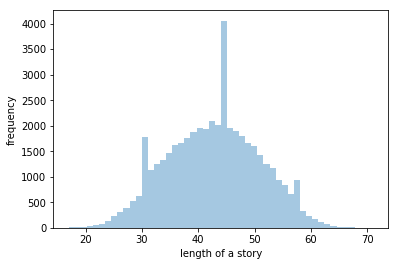

In [151]:
ax=sns.distplot(doc_length, kde=False)
ax.set(xlabel='length of a story', ylabel='frequency')
plt.show()

In [100]:
corpus_list=[]
for i in range(len(corpus)):
    corpus_list+=corpus[i].words
word_count=[word for word in corpus_list if word not in STOP_WORDS]
corpus_counts=Counter(word_count)
corpus_counts.most_common(15)

[('went', 9863),
 ('day', 9631),
 ('decided', 8742),
 ('got', 8456),
 ('wanted', 6938),
 ('new', 6126),
 ('home', 5476),
 ('time', 4621),
 ('took', 4619),
 ('friends', 4305),
 ('didn', 4142),
 ('found', 4003),
 ('school', 3879),
 ('told', 3658),
 ('friend', 3618)]

In [ ]:
list_pos=[(doc, 1) for doc in train_pos]
list_neg=[(doc, -1) for doc in train_neg]
train_list=list_pos+list_tag

In [ ]:
train_targets, train_regressors = zip(*train_list)

In [12]:
X = []
for i in range(len(train_targets)):
    X.append(model.infer_vector(train_targets[i]))
train_x = np.asarray(X)

NameError: name 'train_targets' is not defined

In [ ]:
list_pos_t=[(doc, 1) for doc in test_pos]
list_neg_t=[(doc, -1) for doc in test_neg]
test_list=list_pos_t+list_neg_t
test_targets, test_regressors = zip(*test_list=list_pos_t+list_neg_t)

In [ ]:
Y = np.asarray(train_regressors)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
train_y = le.transform(Y)
np.mean(train_y)

In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(train_x, train_y)

In [ ]:
test_list = []
for i in range(len(test_targets)):
    test_list.append(model.infer_vector(test_targets[i]))
test_x = np.asarray(test_list)
test_Y = np.asarray(test_regressors)
test_y = le.transform(test_Y)

In [ ]:
preds = logreg.predict(test_x)

In [ ]:
sum(preds == test_y) / len(test_y)